In [320]:
import numpy as np
import scipy.special as sp
from scipy.optimize import root

n_core = 1.465
n_clad = 1.445
r_core = 12e-6
wavelength = 1.064e-6
n_modes = 2

n_samples = 128 # Number of spatial samples
px_size = 0.5e-6
win_size = n_samples*px_size # Window dimension
step = win_size / n_samples
x = np.linspace(-win_size/2, +win_size/2+step, n_samples)
X, Y = np.meshgrid(x,x)
R = np.sqrt(np.square(X) + np.square(Y))
A = np.arctan2(Y, X)

In [321]:
NA = np.sqrt(n_core ** 2 - n_clad ** 2)
celer = 3e8
omega = 2 * np.pi * celer / wavelength
mu0 = 4 * np.pi * 1e-7
epsilon0 = 1e-9 / (36 * np.pi)
eps_core = epsilon0 * (n_core ** 2)
eps_clad = epsilon0 * (n_clad ** 2)
k0 = 2 * np.pi / wavelength
V = 2 * np.pi * r_core * NA / wavelength
co = n_core ** 2 / n_clad ** 2

print(np.floor(np.square(V) / 8))

36.0


In [322]:
lbda = wavelength
a = r_core
n1 = n_core
tol = 1e-9
v = V
jv = sp.jv
kn = sp.kn

roots = [0]
m = 0
modes_number = 0

modes = {
    'beta': [],
    'u': [],
    'w': [],
    'm': [],
    'l': [],
    'number': 0,
}

interval = np.arange(np.spacing(10), v - np.spacing(10), v * 1e-4)


while len(roots):

    def root_func(u):
        w = np.sqrt(v**2 - u**2)
        return jv(m, u) / (u * jv(m - 1, u)) + kn(m, w) / (w * kn(m - 1, w))

    guesses = np.argwhere(np.abs(np.diff(np.sign(root_func(interval)))))
    froot = lambda x0: root(root_func, x0, tol=tol)
    sols = map(froot, interval[guesses])
    roots = [s.x for s in sols if s.success]

    # remove solution outside the valid interval, round the solutions and remove duplicates
    roots = np.unique(
        [np.round(r / tol) * tol for r in roots if (r > 0 and r < v)]
    ).tolist()
    roots_num = len(roots)

    if roots_num:
        degeneracy = 1 if m == 0 else 2

        modes['beta'] = modes['beta'] + [np.sqrt((2 * np.pi / lbda * n1) ** 2 - (r / a) ** 2) for r in roots] * degeneracy
        modes['u'] = modes['u'] + roots * degeneracy
        modes['w'] = modes['w'] + [np.sqrt(v**2 - r**2) for r in roots] * degeneracy
        modes['number'] += roots_num * degeneracy
        modes['m'] = modes['m'] + [m] * roots_num * degeneracy
        modes['l'] = modes['l'] + [x + 1 for x in range(roots_num)] * degeneracy

    m += 1

C:\Users\saucourt\AppData\Local\Temp\ipykernel_10732\1491703224.py:28: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


In [323]:
sorted_idx = np.flip(np.argsort(modes['beta']))

modes['beta'] = np.array(modes['beta'])[sorted_idx]
modes['n_eff'] = modes['beta'] * wavelength / (2 * np.pi)
modes['u'] = np.array(modes['u'])[sorted_idx]
modes['w'] = np.array(modes['w'])[sorted_idx]
modes['m'] = np.array(modes['m'])[sorted_idx]
modes['l'] = np.array(modes['l'])[sorted_idx]


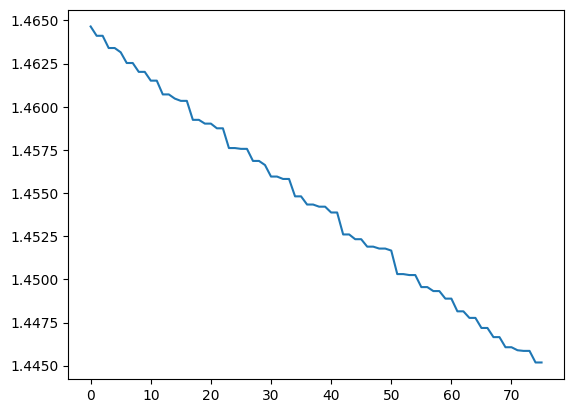

In [324]:
import matplotlib.pyplot as plt

plt.plot(modes['beta'] * wavelength / (2 * np.pi))

In [325]:
def calc_mode(modes, idx, X, Y, r_core):
    R = np.sqrt(np.square(X) + np.square(Y))
    R[R < np.finfo(np.float32).eps] = np.finfo(np.float32).eps
    An = np.arctan2(Y, X)
    
    core = R <= r_core
    clad = R > r_core

    m = modes['m'][idx]
    l = modes['l'][idx]
    u = modes['u'][idx]
    w = modes['w'][idx]
    beta = modes['beta'][idx]

    print(f"LP{m, l}")

    Et = sp.jv(m, u / r_core * R) / sp.jv(m, u) * core + sp.kn(m, w / r_core * R) / sp.kn(m, w) * clad

    if m == 0:
        idx = np.unravel_index(np.argmax(np.abs(Et)), shape=Et.shape)
        if Et[idx[0], idx[1]] < 0:
            Et *= -1
        mode = Et
    else:
        mode = Et * np.cos(m * An)

    mode /= np.sqrt(np.sum(np.abs(mode) ** 2))
    return mode


mode = calc_mode(modes, 0, X, Y, r_core)

LP(0, 1)


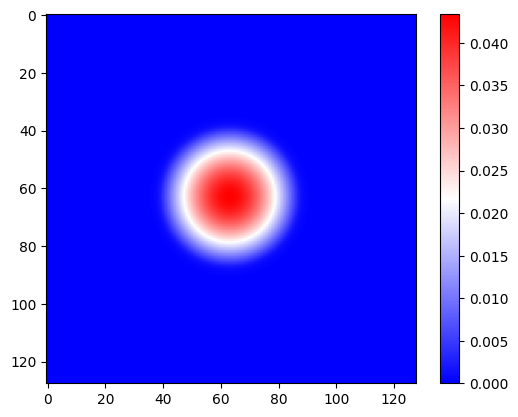

In [326]:
plt.imshow(mode, cmap='bwr')
plt.colorbar()